In [2]:
import cv2
import numpy as np
import struct
import time
import matplotlib.pyplot as plt
import os
import re
import sys
from pathlib import Path

from read_cine import read_cine, convert_cine_to_avi
from track_object import track_object, detect_chamber, update_tracking_result, show_tracking_results

In [31]:
cine_path = r"E:\good_data\He3kA_B500G1kG_pl0t20_uw17t37_P30\Y20241031_He3kA_B500G1kG_pl0t20_uw17t27_y0@810_007.cine"
avi_path = cine_path.replace('.cine', '.avi')

tarr, frarr, dt = read_cine(cine_path)

convert_cine_to_avi(frarr, avi_path)

Reading .cine file...
starting frame number: 200
total frames: 1001
frame rate: 20000
Done reading .cine file (3.2 s)
Converting to E:\good_data\He3kA_B500G1kG_pl0t20_uw17t37_P30\Y20241031_He3kA_B500G1kG_pl0t20_uw17t27_y0@810_007.avi...
Progress: 100/1001 frames
Progress: 200/1001 frames
Progress: 300/1001 frames
Progress: 400/1001 frames
Progress: 500/1001 frames
Progress: 600/1001 frames
Progress: 700/1001 frames
Progress: 800/1001 frames
Progress: 900/1001 frames
Progress: 1000/1001 frames
Progress: 1001/1001 frames
Conversion complete. Saved to E:\good_data\He3kA_B500G1kG_pl0t20_uw17t37_P30\Y20241031_He3kA_B500G1kG_pl0t20_uw17t27_y0@810_007.avi


In [32]:
parr, frarr, cf = track_object(avi_path)

Processing 1001 frames
Hough failed, using contour fallback
Chamber detected at (1122, 1106) with radius 633px
Frame closest to chamber center: 635


Hough failed, using contour fallback
Chamber detected at (1114, 1115) with radius 609px
0.041249999999999995


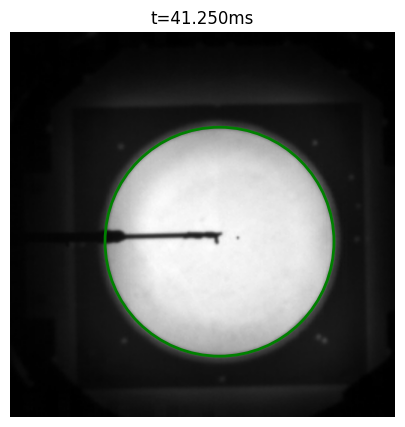

In [34]:
frame_num = 625

cap = cv2.VideoCapture(avi_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
ret, frame = cap.read()
if not ret:
    raise ValueError(f"Could not read frame")

# Detect chamber
(cx, cy), chamber_radius = detect_chamber(frame)

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Display the original frame
plt.figure(figsize=(15, 5))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# Draw the chamber as a circle
chamber_circle = plt.Circle((cx, cy), chamber_radius, fill=False, color='green', linewidth=2)
plt.gca().add_patch(chamber_circle)

plt.title(f"t={tarr[frame_num] * 1e3:.3f}ms")
plt.axis('off')

cap.release()

print(tarr[frame_num])

In [ ]:
v = 9.8*np.sqrt(2*1/9.8) # velocity at center of chamber in m/s

t1 = 0.027 - tarr[cf]
t2 = 0.037 - tarr[cf]
print(t1)
print(t2)

x1 = v*t1 + 0.5*9.8*t1**2
x2 = v*t2 + 0.5*9.8*t2**2

print(x1)
print(x2)

In [20]:
tr_ifn = r"E:\good_data\He3kA_B500G1kG_pl0t20_uw17t37_P30\tracking_results.npy"
show_tracking_results(tr_ifn)

Found 4 entries in tracking results

File: Y20241031_He3kA_B500G1kG_pl0t20_uw17t27_y0@-540_000.cine
  Frame: 274
  Time: -0.026300s

File: Y20241031_He3kA_B500G1kG_pl0t20_uw17t27_y0@-120_001.cine
  Frame: 390
  Time: -0.005500s

File: Y20241031_He3kA_B500G1kG_pl0t20_uw17t27_y0@-470_003.cine
  Frame: 535
  Time: -0.023250s

File: Y20241031_He3kA_B500G1kG_pl0t20_uw17t27_y0@-320_004.cine
  Frame: 685
  Time: -0.015750s



In [35]:
update_tracking_result(tr_ifn, cine_path, cf_new=frame_num, ct_new=tarr[frame_num])

Loaded existing tracking results with 6 entries

No existing entry for Y20241031_He3kA_B500G1kG_pl0t20_uw17t27_y0@810_007.cine

Updated values:
  Frame: 625
  Time: 0.041250s
